In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import timeit
import datetime
import sys
import csv

In [2]:
X_TRAIN_FILE = '../X_train_diagnostic_medication.pkl'
X_TEST_FILE = '../X_test_diagnostic_medication.pkl'
Y_TRAIN_FILE = '../y_train_diagnostic_medication.pkl'
Y_TEST_FILE = '../y_test_diagnostic_medication.pkl'
METRICS_FILE = 'metrics_diagnostic_medication.txt'

In [3]:
script_start_time = datetime.datetime.now()
print('{} started at {}'.format(sys.argv[0], script_start_time))

/Users/dan/.local/share/virtualenvs/machine-learning-for-quality-improvement-NjV9ptfu/lib/python3.6/site-packages/ipykernel_launcher.py started at 2018-06-07 00:51:01.502747


In [4]:
# Generate the rubric dictionary
print('Generating rubric dictionary...', end='')
start_time = timeit.default_timer()
in_read_file = open('../input/large_anon_test_records_for_sharing.csv', mode='r')
out_read_file = open('../input/large_anon_test_records_for_sharing.csv', mode='r')
in_read_csv = csv.reader(in_read_file)
out_read_csv = csv.reader(out_read_file)
in_rubrics = {row[4]: row[3] for row in in_read_csv}
out_rubrics = {row[4]: row[3] for row in out_read_csv}
rubrics = {**in_rubrics, **out_rubrics}
in_read_file.close()
out_read_file.close()

def get_rubric(read_code):    
    return rubrics.get(read_code, 'unknown')
print(' done in {:.2f}s'.format(timeit.default_timer() - start_time), flush=True)

Generating rubric dictionary... done in 4.56s


In [5]:
# Get a list of all patients for train-test splitting
print('Reading data...', end='')
start_time = timeit.default_timer()
X_train, X_test = pd.read_pickle(X_TRAIN_FILE), pd.read_pickle(X_TEST_FILE)
y_train, y_test = pd.read_pickle(Y_TRAIN_FILE), pd.read_pickle(Y_TEST_FILE)
print(' done in {:.2f}s'.format(timeit.default_timer() - start_time), flush=True)
print(y_test.value_counts())

Reading data... done in 0.02s
True     74
False    74
Name: label, dtype: int64


In [6]:
print('Performing grid search and training model...', end='')
start_time = timeit.default_timer()
# param_grid = {
#     'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048],
#     'max_depth': [None],
#     'min_samples_split': [2],
#     'max_features': ['auto', 'log2', None]
# }
param_grid = {
    'n_estimators': [2048],
    'max_depth': [None],
    'min_samples_split': [2],
    'max_features': ['log2']
}
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=16, verbose=50, cv=10 )
grid.fit(X_train, y_train)
print(' done in {:.2f}s'.format(timeit.default_timer() - start_time), flush=True)
print('The best parameters are {} with a score of {}'.format(grid.best_params_, grid.best_score_))

print('Making predictions...', end='')
start_time = timeit.default_timer()
train_preds = grid.predict(X_train)
test_preds = grid.predict(X_test)
print(' done in {:.2f}s'.format(timeit.default_timer() - start_time), flush=True)

train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)
print('Train accuracy: {:.2f} Test accuracy: {:.2f}'.format(train_accuracy * 100, test_accuracy * 100.0))

classification_report = classification_report(y_test, test_preds)
print('Classification report:\n ', classification_report)

confusion_matrix = confusion_matrix(y_test, test_preds)
print('Confusion matrix:\n ', confusion_matrix)

with open(METRICS_FILE, mode='w') as file:
    file.write('Train accuracy: {:.2f} Test accuracy: {:.2f}\n'.format(train_accuracy * 100, test_accuracy * 100.0))
    file.write('Classification report: {}\n'.format(classification_report))
    file.write('Confusion matrix: {}\n'.format(confusion_matrix))
    file.write('Cross validation results: {}\n'.format(grid.cv_results_))
print('Metrics saved at {}'.format(METRICS_FILE))

Performing grid search and training model...Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] max_depth=None, max_features=log2, min_samples_split=2, n_estimators=2048 
[CV] max_depth=None, max_features=log2, min_samples_split=2, n_estimators=2048 
[CV] max_depth=None, max_features=log2, min_samples_split=2, n_estimators=2048 
[CV] max_depth=None, max_features=log2, min_samples_split=2, n_estimators=2048 
[CV] max_depth=None, max_features=log2, min_samples_split=2, n_estimators=2048 
[CV] max_depth=None, max_features=log2, min_samples_split=2, n_estimators=2048 
[CV] max_depth=None, max_features=log2, min_samples_split=2, n_estimators=2048 
[CV] max_depth=None, max_features=log2, min_samples_split=2, n_estimators=2048 
[CV] max_depth=None, max_features=log2, min_samples_split=2, n_estimators=2048 
[CV] max_depth=None, max_features=log2, min_samples_split=2, n_estimators=2048 
[CV]  max_depth=None, max_features=log2, min_samples_split=2, n_estimators=2048, score=0.016666

<module 'matplotlib.pyplot' from '/Users/dan/.local/share/virtualenvs/machine-learning-for-quality-improvement-NjV9ptfu/lib/python3.6/site-packages/matplotlib/pyplot.py'>

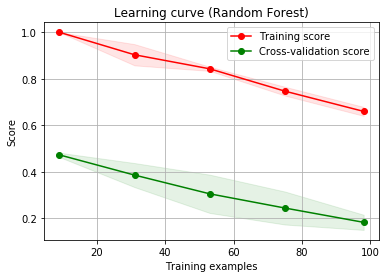

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(grid.best_estimator_, 'Learning curve (Random Forest)', X_test, y_test, n_jobs=16)

In [8]:
print('Sorting importance...', end='')
start_time = timeit.default_timer()
forest = grid.best_estimator_
feature_dict = {get_rubric(f): i for f, i in zip(X_test.columns, forest.feature_importances_)}

importances = pd.DataFrame.from_dict(feature_dict, orient='index').rename(columns={0: 'importance'})

importances.sort_values(by='importance', inplace=True, ascending=False)
importances.to_csv('importances_diagnostic_medication.csv')
importances.to_pickle('importances_diagnostic_medication.pkl')

Sorting importance...

In [9]:
script_end_time = datetime.datetime.now()
print('{} completed at {}'.format(
    sys.argv[0], 
    script_end_time)
)
print('Total time: {}'.format(script_end_time - script_start_time))

/Users/dan/.local/share/virtualenvs/machine-learning-for-quality-improvement-NjV9ptfu/lib/python3.6/site-packages/ipykernel_launcher.py completed at 2018-06-07 01:00:51.091966
Total time: 0:09:49.589219
